In [1]:
import datetime

### UDAF simulator

In [1]:
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import itertools
from data_analytics import save_fig
import string
Alphabet = string.ascii_uppercase




def rotate(l, n):
    """Summary
    Rotate the list l to right(the index increasing direction) for n elements.
    Args:
        l (list): The input list to rotate
        n (integer): The number of elements to rotate

    Returns:
        list: The rotated list
    """
    return l[-n:] + l[:-n]

class Simulator(object):
    def __init__(self, runtimes, worker_num):
        self.msts = list(range(len(runtimes)))
        self.runtimes = runtimes
        self.dist_keys = list(range(worker_num))
    def simulate(self):
        pass

class UDAFSimulator(Simulator):
    def __init__(self, *args, **kwargs):
        super(UDAFSimulator, self).__init__(*args, **kwargs)
    def simulate(self):
        self.grand_schedule = self.generate_schedule()
        grand_runtimes = []
        for subepoch in self.msts:
            all_runtimes = [
                self.runtimes[self.grand_schedule[i][subepoch]]
                for i in self.dist_keys
            ]
            runtime = np.max(all_runtimes)
            grand_runtimes.append(runtime)
        return np.sum(grand_runtimes)

    def generate_schedule(self):
        """ Generate the schedule for models hopping to segments """
        grand_schedule = {}
        for index, dist_key in enumerate(self.dist_keys):
            grand_schedule[dist_key] = rotate(self.msts, index)
        return grand_schedule

class CTQSimulator(Simulator):
    def __init__(self, *args, **kwargs):
        super(CTQSimulator, self).__init__(*args, **kwargs)
        self.model_keys = self.msts
        self.model_info_ordered = defaultdict(list)
    def _get_runnable_model(self, target_dist_key, model_dist_pairs,
                            model_states):
        for model_key, dist_key in model_dist_pairs:
            # worker matches and model idle|
            if dist_key == target_dist_key and not model_states[model_key]:
                return model_key
        return -1


    def init_epoch(self):
        self.return_dict_job = {}
        self.procs = {}
        self.next_finish = {}
        self.model_dist_pairs = [(i, j) for i in self.model_keys
                                 for j in self.dist_keys]
        random.shuffle(self.model_dist_pairs)
        self.model_states = {i: False for i in self.model_keys}
        self.dist_states = {i: False for i in self.dist_keys}
        self.model_on_dist = [-1 for _ in self.dist_keys]

        for job_key in self.model_dist_pairs:
            self.return_dict_job[job_key] = {
                'status': None
            }
    def simulate(self):
        self.init_epoch()
        self.train_one_epoch()
        return self.curr_time
    def train_one_epoch(self):
        self.curr_time = 0
        while len(self.model_dist_pairs) > 0:
            for dist_key in self.dist_keys:
                if not self.dist_states[dist_key]:
                    #                     Assign to idle worker
                    model_key = self._get_runnable_model(
                        dist_key, self.model_dist_pairs, self.model_states)
                    if model_key != -1:
                        self.assign_one_model_to_dist(
                            model_key, dist_key, self.curr_time)
            first_finish = None
            next_time = None
            for dist_key in self.dist_keys:
                model_key = self.model_on_dist[dist_key]
                if model_key != -1:
                    dist_key_next_time = self.next_finish[dist_key]
                    if next_time is None or dist_key_next_time < next_time :
                        next_time = dist_key_next_time
                        first_finish = dist_key
            if first_finish is not None and next_time is not None:
                model_key = self.model_on_dist[first_finish]
                self.peek_job(model_key, first_finish)
                self.curr_time = next_time
    def assign_one_model_to_dist(self, model_key, dist_key, curr_time, epoch=None):
        job_key = (model_key, dist_key)
        self.model_states[model_key] = True
        self.dist_states[dist_key] = True
        self.model_on_dist[dist_key] = model_key
        self.next_finish[dist_key] = curr_time + self.runtimes[model_key]
        self.return_dict_job[job_key] = {
                    'dist_key': dist_key,
                    'model_key': model_key,
                    'start_time': curr_time,
                    'end_time': curr_time + self.runtimes[model_key]
                }
    def peek_job(self, model_key, dist_key):
        job_key = (model_key, dist_key)
        job_dict = self.return_dict_job[job_key]
        # sub-epoch completed
        self.model_dist_pairs.remove(job_key)
        self.model_states[model_key] = False
        self.dist_states[dist_key] = False
        self.model_on_dist[dist_key] = -1
        self.model_info_ordered[model_key].append(job_dict)
        self.next_finish[dist_key] = None

def predict_udaf_runtime(W, M, scale):
    return prop ** (W) * 1 * M + (1 - prop ** (W)) * scale * M
def predict_ctq_runtime(M, l_mean):
    return M * l_mean
def bernoulli(prop=0.9, scale=100, size=256, new_way=False):
#    
    if new_way:
        num_fast = round(size * prop)
        num_slow = size - num_fast
        runtimes = np.array([scale for _ in range(num_slow)] + [1 for _ in range(num_fast)])
        np.random.shuffle(runtimes)
    else:
        runtimes = np.random.binomial(1, prop, size)
        runtimes[runtimes==0] = scale
        runtimes[runtimes==1] = 1
    print("Number of slow models: {}".format(len(runtimes[runtimes==scale])))
    print("Number of fast models: {}".format(len(runtimes[runtimes==1])))
# 
    return runtimes

class SimulatorRunner(object):
    def __init__(self, runtimes, max_worker=32):
        self.runtimes = runtimes
        random.shuffle(self.runtimes)
        self.lmax = np.max(runtimes)
        self.lmin = np.min(runtimes)
        self.scale = self.lmax / self.lmin
        self.lmean = np.mean(runtimes)
        print("Lmax:{}".format(self.lmax))
        print("Lmean:{}".format(self.lmean))
        print("Lmax/Lmean:{}".format(self.lmax / self.lmean ))
        self.res = []
        self.res_schema = ['worker_num', 'udaf_runtime', 'predicted_udaf_runtime', 'ctq_runtime', 'predicted_ctq_runtime', 'speed_up', 'predicted_speed_up']
        self.max_worker = max_worker
    def simulate(self, runtimes, worker_num):
        udaf = UDAFSimulator(runtimes, worker_num)
        udaf_runtime = udaf.simulate()
        predicted_udaf_runtime = predict_udaf_runtime(worker_num, len(self.runtimes), self.scale)
        print ("UDAF runtime: {}, predicted: {}".format(udaf_runtime, predicted_udaf_runtime))
        ctq = CTQSimulator(runtimes, worker_num) 
        ctq_runtime = ctq.simulate()
        predicted_ctq_runtime = predict_ctq_runtime(len(self.runtimes), self.lmean)
        print ("CTQ runtime: {}, predicted: {}".format(ctq_runtime, predicted_ctq_runtime))
        speed_up = udaf_runtime / ctq_runtime
        predicted_speed_up = predicted_udaf_runtime / predicted_ctq_runtime
        print ("CTQ speed-up over UDAF: {}, predicted: {}".format(speed_up, predicted_speed_up))
        return udaf_runtime, predicted_udaf_runtime, ctq_runtime, predicted_ctq_runtime, speed_up, predicted_speed_up
    def run(self):
        for worker_num in range(1, self.max_worker + 1):
            udaf_runtime, predicted_udaf_runtime, ctq_runtime, predicted_ctq_runtime, speed_up, predicted_speed_up = self.simulate(self.runtimes, worker_num)
            self.res.append((worker_num, udaf_runtime, predicted_udaf_runtime, ctq_runtime, predicted_ctq_runtime, speed_up, predicted_speed_up))
            
        res_df = pd.DataFrame(self.res)
        res_df.columns = self.res_schema
        return res_df
class PlotterHetero(object):
    def __init__(self):
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        self.ax.set_xlabel('W (Number of Workers)')
        self.ax.set_ylabel('Speed up of CTQ over UDAF')
    def plot(self, *args, **kwargs):
        x = args[0]
        self.ax.plot(linewidth=2, *args, **kwargs)
#         self.ax.set_xticks([1] + x[1::2])
    def conclude(self):
        self.ax.legend(ncol=2, loc='lower center')
        self.fig.tight_layout()        



In [5]:
random.seed(2020)
np.random.seed(2020)
plotters = []
scale = 20
props = [0.1, 0.5, 0.8]
size = [512]
combs = list(itertools.product(props, size))
combs = [(0.1, 64)] + combs + [(0.9, 4096)]
combs = sorted(combs, key=lambda x:x[1])
font = {'size'   : 16}

matplotlib.rc('font', **font)

In [6]:
combs = [(0.1, 64), (0.1, 512), (0.5, 512), (0.8, 512), (0.9, 4096)]

Number of slow models: 59
Number of fast models: 5
Lmax:20
Lmean:18.515625
Lmax/Lmean:1.080168776371308
UDAF runtime: 1185, predicted: 1158.4
CTQ runtime: 1185, predicted: 1185.0
CTQ speed-up over UDAF: 1.0, predicted: 0.9775527426160339
UDAF runtime: 1261, predicted: 1267.8400000000001
CTQ runtime: 1185, predicted: 1185.0
CTQ speed-up over UDAF: 1.0641350210970464, predicted: 1.0699071729957808
UDAF runtime: 1280, predicted: 1278.784
CTQ runtime: 1185, predicted: 1185.0
CTQ speed-up over UDAF: 1.080168776371308, predicted: 1.0791426160337554
UDAF runtime: 1280, predicted: 1279.8784
CTQ runtime: 1205, predicted: 1185.0
CTQ speed-up over UDAF: 1.062240663900415, predicted: 1.0800661603375528
UDAF runtime: 1280, predicted: 1279.98784
CTQ runtime: 1185, predicted: 1185.0
CTQ speed-up over UDAF: 1.080168776371308, predicted: 1.0801585147679325
UDAF runtime: 1280, predicted: 1279.9987840000001
CTQ runtime: 1185, predicted: 1185.0
CTQ speed-up over UDAF: 1.080168776371308, predicted: 1.08016

CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9348, predicted: 9328.0
CTQ speed-up over UDAF: 1.0954214805305948, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373928
UDAF runtime: 10240, predicted: 10240.0
CTQ runtime: 9328, predicted: 9328.0
CTQ speed-up over UDAF: 1.097770154373928, predicted: 1.097770154373

CTQ runtime: 2543, predicted: 2526.0
CTQ speed-up over UDAF: 3.907196224931184, predicted: 3.7230289639312115
UDAF runtime: 10050, predicted: 9571.496930312192
CTQ runtime: 2526, predicted: 2526.0
CTQ speed-up over UDAF: 3.978622327790974, predicted: 3.7891911838132195
UDAF runtime: 10126, predicted: 9705.197544249753
CTQ runtime: 2541, predicted: 2526.0
CTQ speed-up over UDAF: 3.9850452577725304, predicted: 3.8421209597188257
UDAF runtime: 10164, predicted: 9812.158035399803
CTQ runtime: 2526, predicted: 2526.0
CTQ speed-up over UDAF: 4.02375296912114, predicted: 3.884464780443311
UDAF runtime: 10202, predicted: 9897.726428319842
CTQ runtime: 2526, predicted: 2526.0
CTQ speed-up over UDAF: 4.038796516231195, predicted: 3.9183398370228986
UDAF runtime: 10240, predicted: 9966.181142655872
CTQ runtime: 2545, predicted: 2526.0
CTQ speed-up over UDAF: 4.023575638506876, predicted: 3.9454398822865686
UDAF runtime: 10240, predicted: 10020.944914124699
CTQ runtime: 2542, predicted: 2526.0
CTQ

CTQ runtime: 11881, predicted: 11867.0
CTQ speed-up over UDAF: 6.583200067334399, predicted: 6.625174896636857
UDAF runtime: 78614, predicted: 78950.85544855062
CTQ runtime: 11884, predicted: 11867.0
CTQ speed-up over UDAF: 6.615112756647593, predicted: 6.652975094678572
UDAF runtime: 78956, predicted: 79247.76990369556
CTQ runtime: 11881, predicted: 11867.0
CTQ speed-up over UDAF: 6.645568554835451, predicted: 6.677995272916117


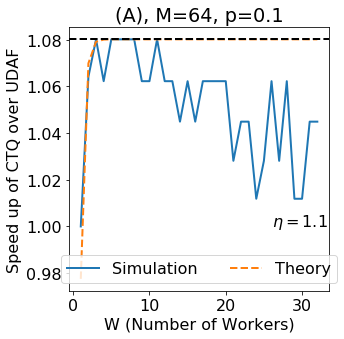

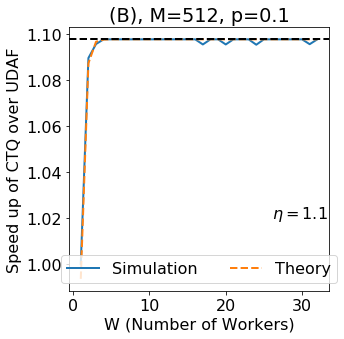

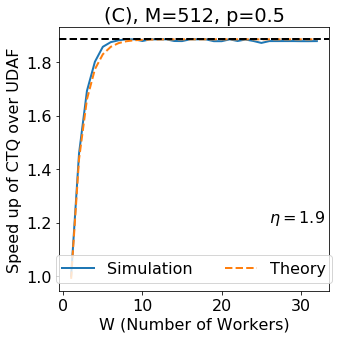

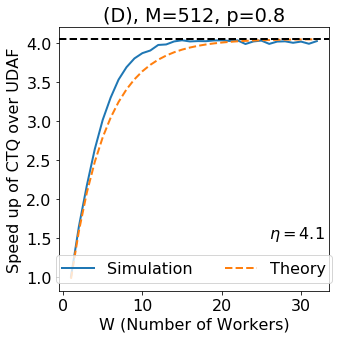

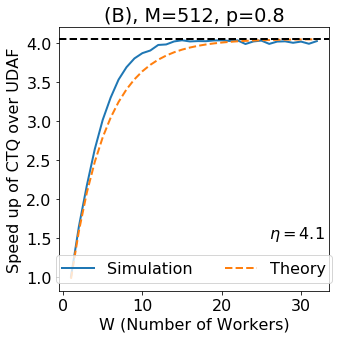

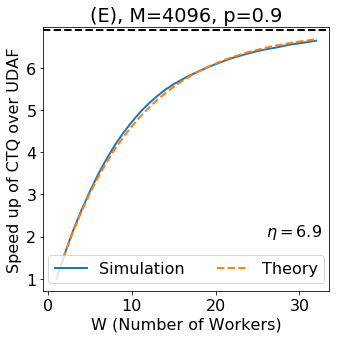

In [7]:
for idx, (prop, size) in enumerate(combs):
    runtimes = bernoulli(prop=prop, scale=scale, size=size)
    runner = SimulatorRunner(runtimes)
    res_df = runner.run()
    plotter = PlotterHetero()
    plotter.plot(res_df['worker_num'], res_df['speed_up'], label='Simulation')
    plotter.plot(res_df['worker_num'], res_df['predicted_speed_up'], '--', label='Theory')
    plotter.ax.set_title("({}), M={}, p={}".format(Alphabet[idx], size, prop))
    eta = runner.lmax/runner.lmean
    yticks = plotter.ax.get_yticks()
    tick_spacing = (yticks[-1] - yticks[0]) / (len(yticks) - 1)
    plotter.ax.annotate(r'$\eta={}$'.format(round(eta, 1)), xy=(26, yticks[2]))
    plotter.ax.axhline(eta, color='k', linestyle='--', linewidth=2)
    plotter.conclude()
#     plotter.ax.legend(ncol=2, loc='lower center')
    save_fig(plotter.fig, "hetero_M-{}_p-{}".format(size, prop))
    plotters.append(plotter)
    if idx == len(combs) - 2:
        idx = 1
        plotter = PlotterHetero()
        plotter.plot(res_df['worker_num'], res_df['speed_up'], label='Simulation')
        plotter.plot(res_df['worker_num'], res_df['predicted_speed_up'], '--', label='Theory')
        plotter.ax.set_title("({}), M={}, p={}".format(Alphabet[idx], size, prop))
        eta = runner.lmax/runner.lmean
        yticks = plotter.ax.get_yticks()
        tick_spacing = (yticks[-1] - yticks[0]) / (len(yticks) - 1)
        plotter.ax.annotate(r'$\eta={}$'.format(round(eta, 1)), xy=(26, yticks[2]))
        plotter.ax.axhline(eta, color='k', linestyle='--', linewidth=2)
        plotter.conclude()
#         plotter.ax.legend(ncol=2, loc='lower center')
        save_fig(plotter.fig, "hetero_M-{}_p-{}-tB".format(size, prop))
        plotters.append(plotter)
    
    
    

Number of slow models: 10
Number of fast models: 38
0.8 [1.         1.         1.         1.         1.         1.
 7.94269304 1.         1.         1.         1.         1.
 1.         1.         7.94269304 1.         1.         1.
 7.94269304 1.         1.         1.         1.         1.
 1.         1.         1.         7.94269304 1.         7.94269304
 1.         1.         1.         7.94269304 1.         1.
 7.94269304 1.         1.         1.         1.         7.94269304
 1.         1.         1.         7.94269304 7.94269304 1.        ]
Lmax:7.942693044033185
Lmean:2.4463943841735802
Lmax/Lmean:3.2466936220164344
UDAF runtime: 117.42693044033184, predicted: 114.64985322271856
CTQ runtime: 117.42693044033187, predicted: 117.42693044033186
CTQ speed-up over UDAF: 0.9999999999999998, predicted: 0.9763505934524584
UDAF runtime: 166.02578174856416, predicted: 167.9697358008934
CTQ runtime: 117.42693044033189, predicted: 117.42693044033186
CTQ speed-up over UDAF: 1.4138646145819744

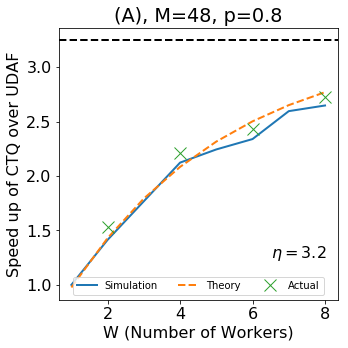

In [128]:
actual = [1.531456212116688, 2.208525284617421, 2.433744799836323, 2.729005059021923][::-1]
actual_x = [8, 6, 4, 2]
seed = 2020
random.seed(seed)
np.random.seed(seed)
plotters = []
scale = 7.942693044033185
props = [0.8]
size = [48]
combs = list(itertools.product(props, size))
combs = combs
combs = sorted(combs, key=lambda x:x[1])
for idx, (prop, size) in enumerate(combs):
    runtimes = bernoulli(prop=prop, scale=scale, size=size, new_way=True)
#     runtimes = [1,1,1,1,1,1,1,5,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1,5]
    print(prop, np.array(runtimes))
    runner = SimulatorRunner(runtimes, max_worker=8)
    res_df = runner.run()
    plotter = PlotterHetero()
    plotter.plot(res_df['worker_num'], res_df['speed_up'], label='Simulation')
    plotter.plot(res_df['worker_num'], res_df['predicted_speed_up'], '--', label='Theory')
    plotter.ax.plot(actual_x, actual, 'x', markersize=12, label='Actual')
    plotter.ax.set_title("({}), M={}, p={}".format(Alphabet[idx], size, prop))
    eta = runner.lmax/runner.lmean
    yticks = plotter.ax.get_yticks()
    tick_spacing = (yticks[-1] - yticks[0]) / (len(yticks) - 1)
    plotter.ax.annotate(r'$\eta={}$'.format(round(eta, 1)), xy=(6.5, yticks[2]))
    plotter.ax.axhline(eta, color='k', linestyle='--', linewidth=2)
    plotter.ax.legend(ncol=3, loc='lower center', fontsize=10)
    plotters.append(plotter)
    save_fig(plotter.fig, "hetero_M-{}_p-{}".format(size, prop))
    